<a href="https://colab.research.google.com/github/22Ifeoma22/22Ifeoma22/blob/main/TF2_0_Transfer_Learning_with_Data_Augumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as Pretrainedmodel, \
 preprocess_input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from glob import glob
from tensorflow.keras.models import Model

In [3]:
!wget --passive-ftp --prefer-family=ipv4 --ftp-user datasets@mmspgdata.epfl.ch \
--ftp-password ohsh9jah4T -r ftp://tremplin.epfl.ch/FoodImage/


--2024-06-25 17:07:18--  ftp://tremplin.epfl.ch/FoodImage/
           => ‘tremplin.epfl.ch/FoodImage/.listing’
Resolving tremplin.epfl.ch (tremplin.epfl.ch)... 128.178.218.41, 2001:620:618:1da:7:80b2:da01:3
Connecting to tremplin.epfl.ch (tremplin.epfl.ch)|128.178.218.41|:21... connected.
Logging in as datasets@mmspgdata.epfl.ch ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /FoodImage ... done.
==> PASV ... done.    ==> LIST ... done.

tremplin.epfl.ch/Fo     [ <=>                ]     221  --.-KB/s    in 0s      

2024-06-25 17:07:35 (498 KB/s) - ‘tremplin.epfl.ch/FoodImage/.listing’ saved [221]

Removed ‘tremplin.epfl.ch/FoodImage/.listing’.
--2024-06-25 17:07:35--  ftp://tremplin.epfl.ch/FoodImage/Food-11.zip
           => ‘tremplin.epfl.ch/FoodImage/Food-11.zip’
==> CWD not required.
==> PASV ... done.    ==> RETR Food-11.zip ... done.
Length: 1163037552 (1.1G)

tremplin.epfl.ch/Fo 100%[===================>]   1.08G  34.7MB/s    in 33s    

In [4]:
!ls tremplin.epfl.ch/

FoodImage


In [5]:
!ls tremplin.epfl.ch/FoodImage

Food-11.zip  Food-5K.zip  NutriTakeAPP.apk


In [6]:
!unzip -qq -o /content/tremplin.epfl.ch/FoodImage/Food-5K.zip

In [7]:
!ls

evaluation  __MACOSX  sample_data  training  tremplin.epfl.ch  validation


In [8]:
!ls training

0_0.jpg     0_1338.jpg	0_325.jpg  0_663.jpg  1_0.jpg	  1_1338.jpg  1_325.jpg  1_663.jpg
0_1000.jpg  0_1339.jpg	0_326.jpg  0_664.jpg  1_1000.jpg  1_1339.jpg  1_326.jpg  1_664.jpg
0_1001.jpg  0_133.jpg	0_327.jpg  0_665.jpg  1_1001.jpg  1_133.jpg   1_327.jpg  1_665.jpg
0_1002.jpg  0_1340.jpg	0_328.jpg  0_666.jpg  1_1002.jpg  1_1340.jpg  1_328.jpg  1_666.jpg
0_1003.jpg  0_1341.jpg	0_329.jpg  0_667.jpg  1_1003.jpg  1_1341.jpg  1_329.jpg  1_667.jpg
0_1004.jpg  0_1342.jpg	0_32.jpg   0_668.jpg  1_1004.jpg  1_1342.jpg  1_32.jpg	 1_668.jpg
0_1005.jpg  0_1343.jpg	0_330.jpg  0_669.jpg  1_1005.jpg  1_1343.jpg  1_330.jpg  1_669.jpg
0_1006.jpg  0_1344.jpg	0_331.jpg  0_66.jpg   1_1006.jpg  1_1344.jpg  1_331.jpg  1_66.jpg
0_1007.jpg  0_1345.jpg	0_332.jpg  0_670.jpg  1_1007.jpg  1_1345.jpg  1_332.jpg  1_670.jpg
0_1008.jpg  0_1346.jpg	0_333.jpg  0_671.jpg  1_1008.jpg  1_1346.jpg  1_333.jpg  1_671.jpg
0_1009.jpg  0_1347.jpg	0_334.jpg  0_672.jpg  1_1009.jpg  1_1347.jpg  1_334.jpg  1_672.jpg
0_100.jpg   0_1

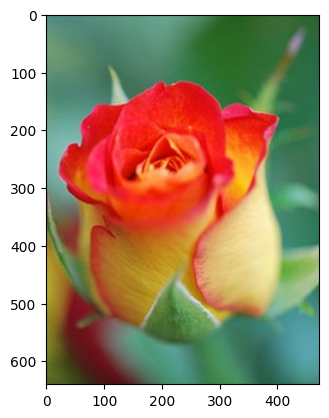

In [9]:
# look at an image for fun
plt.imshow(image.load_img("training/0_808.jpg"))
plt.show()

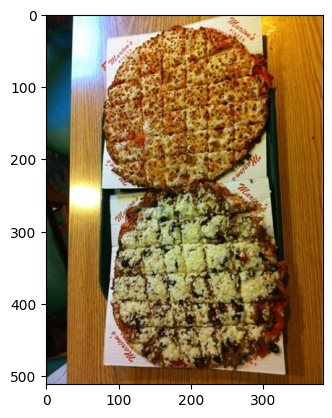

In [10]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

In [11]:
!mkdir data

In [12]:
# Make directories to store the data keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [13]:
# Move the images
# Note: we will consider 'training' to be the train set
#      'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [14]:
train_path = 'data/train'
valid_path = 'data/test'

In [15]:
!ls Food-5K/training
!ls Food-5K/validation


ls: cannot access 'Food-5K/training': No such file or directory
ls: cannot access 'Food-5K/validation': No such file or directory


In [16]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [17]:
# Useful  for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [18]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

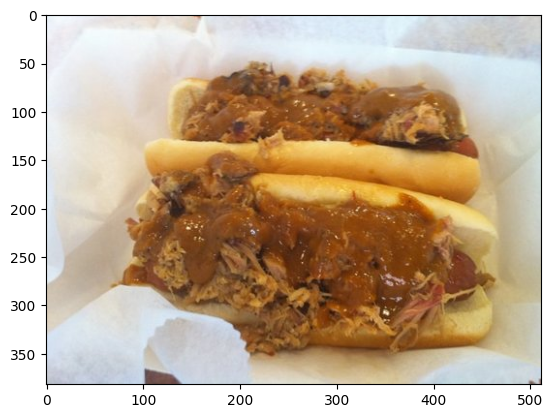

In [19]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [20]:
from tensorflow.keras.applications import VGG16  # or any other model you prefer

# Load the pretrained model
ptm = VGG16(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

# Print the model summary
ptm.summary()


58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [21]:
# freeze pretrained model weights
ptm.trainable = False

In [22]:
# map the data into feature vectors
# Keras image data generator returns classes one-hot encoded

k = len(folders) # number of classes
x = Flatten() (ptm.output)
x = Dense(k, activation='softmax')(x)

In [23]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [24]:
# view  the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [25]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
)



In [26]:
batch_size = 128

# craete generators
train_generator = gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,

)


Found 3000 images belonging to 2 classes.


In [27]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']

)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Specify the image size
IMAGE_SIZE = [224, 224]  # Modify this based on your model's requirements

# Load the pretrained model
ptm = VGG16(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

# Define your model
model = models.Sequential([
    ptm,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Create data generators
batch_size = 128

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    'data/test',
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

# Fit the model
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=int(np.ceil(len(train_generator.filenames) / batch_size)),
    validation_steps=int(np.ceil(len(valid_generator.filenames) / batch_size))
)


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<ipython-input-28-836a40f7281d>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10


In [ ]:
# accuraccies

plt.plot(r.history['accuracy'], labels='train accu')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()